In [1]:
%pylab inline
import numpy as np
from scipy.special import ellipk as K
from scipy.optimize import fsolve as solve

Populating the interactive namespace from numpy and matplotlib


In [63]:
RO4003C1 = {"name": "RO4003C                ",
      "thikness": 203e-6,
      "metal thikness": 18e-6,
      "eps": 3.38,
      "cpw_b_min": 0}

RO4003C2 = {"name": "RO4003C                ",
      "thikness": 305e-6,
      "metal thikness": 18e-6,
      "eps": 3.38,
      "cpw_b_min": 0}

RO4003C3 = {"name": "RO4003C                ",
      "thikness": 508e-6,
      "metal thikness": 18e-6,
      "eps": 3.38,
      "cpw_b_min": 0}


RO4350B1 = {"name": "RO4350B                ",
      "thikness": 254e-6,
      "metal thikness": 18e-6,
      "eps": 3.48,
      "cpw_b_min": 0}

RO4350B2 = {"name": "RO4350B                ",
      "thikness": 338e-6,
      "metal thikness": 18e-6,
      "eps": 3.48,
      "cpw_b_min": 0}

RO4350B3 = {"name": "RO4350B                ",
      "thikness": 508e-6,
      "metal thikness": 18e-6,
      "eps": 3.48,
      "cpw_b_min": 0}

ArlonAD10001 = {"name": "Arlon AD1000         ",
      "thikness": 508e-6,
      "metal thikness": 18e-6,
      "eps": 10.0,
      "cpw_b_min": 0}

ArlonAD10002 = {"name": "Arlon AD1000         ",
      "thikness": 635e-6,
      "metal thikness": 18e-6,
      "eps": 10.2,
      "cpw_b_min": 0}

ArlonAD10003 = {"name": "Arlon AD1000         ",
      "thikness": 1270e-6,
      "metal thikness": 18e-6,
      "eps": 10.6,
      "cpw_b_min": 0}

ArlonTC600 = {"name": "Arlon TC600            ",
      "thikness": 508e-6,
      "metal thikness": 18e-6,
      "eps": 6.15,
      "cpw_b_min": 0}




# materials = [RO4003C1, RO4003C2, RO4003C3, RO4350B0, RO4350B01, RO4350B1, RO4350B2, RO4350B3,
#              ArlonTC600, ArlonAD10001, ArlonAD10002, ArlonAD10003]
# materials = [RO4003C1, RO4003C2, RO4003C3, RO4350B1, RO4350B2, RO4350B3,
#              ArlonTC600, ArlonAD10001, ArlonAD10002, ArlonAD10003]

materials = [RO4003C1, RO4003C2, RO4003C3, RO4350B1, RO4350B2, RO4350B3,
             ArlonTC600, ArlonAD10001, ArlonAD10002, ArlonAD10003]

In [64]:
def cpw_impedance(s, w, t, h1, h2, e1, e2): # работает
    c = 3.*1e8 
    e0 = 8.85418*1e-12
    
    def prime(value):
        return np.sqrt(1 - value**2)
    
    h1 = h1
    h2 = h2
    h3 = h1
    h4 = h2
    pi = np.pi
    
    d = 2 * t / pi
    a = s / 2.
    b = s / 2. + w
    w1 = a + d / 2 - d * np.log(d / a) / 2 + 3 / 2 * d * np.log(2) - d / 2 * np.log((a + b) / (b - a))
    w2 = b - d / 2 + d * np.log(d / a) / 2 - 3 / 2 * d * np.log(2) + d / 2 * np.log((a + b) / (b - a))
    s = 2 * w1
    w = w2 - w1
    b = s + 2*w
    
    k1 = np.tanh(pi*s/4/h1)/np.tanh(pi*b/4/h1)
    k2 = np.tanh(pi*s/4/h2)/np.tanh(pi*b/4/h2)

    k1prime = prime(k1)
    k2prime = prime(k2)
    
    denom = K(k1**2)/K(k1prime**2) + K(k2**2)/K(k2prime**2)
    q1 = K(k1**2)/K(k1prime**2)/denom
    q2 = K(k2**2)/K(k2prime**2)/denom
    
    eeff = 1 + q1*(e1-1) + q2*(e2-1)
    z0 = 60*pi/np.sqrt(eeff)/denom
    return z0

def cpw_50(b, t, h1, h2, e1, e2): # работает
    def func(s, b, t, h1, h2, e1, e2):
        w = (b - s)/2.
        return cpw_impedance(s, w, t, h1, h2, e1, e2) - 50.
    s = solve(func, 10e-6, args = (b, t, h1, h2, e1, e2), xtol = 1e-9)[0]
    w = (b - s)/2.
    return s, w

cpw_50_vec = np.vectorize(cpw_50)

def cpw_50_s(s, t, h1, h2, e1, e2, init_point): # работает
    def func(b, s, t, h1, h2, e1, e2):
        w = (b - s)/2.
        return cpw_impedance(s, w, t, h1, h2, e1, e2) - 50.
    b = solve(func, init_point, args = (s, t, h1, h2, e1, e2), xtol = 1e-12, maxfev = 1000)[0]
    w = (b - s)/2.
    return b, w

def cpw_50_w(w, t, h1, h2, e1, e2, init_point): # работает
    def func(b, w, t, h1, h2, e1, e2):
        s = b - 2*w
        return cpw_impedance(s, w, t, h1, h2, e1, e2) - 50.
    b = solve(func, init_point, args = (w, t, h1, h2, e1, e2), xtol = 1e-12, maxfev = 1000)[0]
    s = b - 2*w
    return b, s



In [65]:
cpw_impedance(1000e-6, 1000e-6, 18e-6, 1000e-6, 100, 10, 1)

45.01846447005754

In [66]:
s, w = cpw_50(1000e-6, 18e-6, 1000e-6, 100, 10, 1)
print(s*1e6, w*1e6)

393.85624010389665 303.0718799480517


In [67]:
def shielded_stripline_impedance(w, g, b, t, e):# работает
    e0 = 8.85418*1e-12
    pi = np.pi
    Cf = 1
    Cf *= e0/pi
    Cf *= (b*np.log((2*b-t)/t)/(b-t) + np.log(t*(2*b-t)/(b-t)**2))
    Cf0 = 2*e0/pi*np.log(2)
    z0 = 1
    z0 *= 30*pi/np.sqrt(e)
    z0 = z0/(w/(b-t) + 2*Cf*np.log(1+1/np.tanh(pi*g/b))/pi/Cf0)
    return z0

In [68]:
shielded_stripline_impedance(w = 1000e-6, g = 500e-6, b = 2000e-6, t = 18e-6, e = 10)

26.637128043147026

In [69]:
def fivewire_line_impedance(d, D, e):
    z0 = 120*2.5044*np.log(D/0.933/d)/np.sqrt(e)
    return z0

In [81]:


def open_cpw_analyse(work_array, b, shielding_high):
    
    colors = ['#1f77b4',
          '#ff7f0e',
          '#2ca02c',
          '#d62728',
          '#9467bd',
          '#8c564b',
          '#e377c2',
          '#7f7f7f',
          '#bcbd22',
          '#17becf',
          '#1a55FF',
          '#4faf7e']
    
    fig, ax = plt.subplots(1, 2)
    for mat in work_array:
        s_loc, w_loc = cpw_50_vec(b, mat['metal thikness'], mat['thikness'], shielding_high, mat['eps'], 1)

        name = str(mat['name']) + ", " + str(int(mat['thikness']*1e6)) + ", "  + str(mat['eps'])
        
        if mat['name'][0] == 'A':        
            ax[0].plot(b*1e6, s_loc*1e6, '--', label = name)
            ax[1].plot(b*1e6, w_loc*1e6, '--', label = name)
        else:
            ax[0].plot(b*1e6, s_loc*1e6, label = name)
            ax[1].plot(b*1e6, w_loc*1e6, label = name)

        
#     plt.legend(loc = 'upper left')
    ax[0].grid(True)
    ax[1].grid(True)
#     ax[0].set_xlim(90, 600)
#     ax[1].set_xlim(90, 600)
#     ax[0].axhline(y=75, color="black", linestyle="--")
#     ax[1].axhline(y=75, color="black", linestyle="--")
#     ax[0].axhline(y=100, color="grey", linestyle="--")
#     ax[1].axhline(y=100, color="grey", linestyle="--")
#     ax[0].axhline(y=125, color="#A9A9A9", linestyle="--")
#     ax[1].axhline(y=125, color="#A9A9A9", linestyle="--")
    
    ax[0].axhline(y=75, color="black")
    ax[1].axhline(y=75, color="black")
    ax[0].axhline(y=100, color="grey")
    ax[1].axhline(y=100, color="grey")
    ax[0].axhline(y=125, color="#A9A9A9")
    ax[1].axhline(y=125, color="#A9A9A9")
    
    ax[0].set_xlabel(r'$b, \mu m$',fontsize = 'large')
    ax[0].set_ylabel(r'$s, \mu m$',fontsize = 'large')
    ax[1].set_xlabel(r'$b, \mu m$',fontsize = 'large')
    ax[1].set_ylabel(r'$w, \mu m$',fontsize = 'large')
    
    fig.set_figwidth(16)    
    fig.set_figheight(6)
    fig.savefig('open_cpw_1', dpi = 300)
    plt.show()
    
    
    fig, ax = plt.subplots()
    for mat in work_array:
        s_loc, w_loc = cpw_50_vec(b, mat['metal thikness'], mat['thikness'], shielding_high, mat['eps'], 1)

        name = str(mat['name']) + "   " + str(int(mat['thikness']*1e6)) + "   "  + str(mat['eps'])
        

        
        if mat['name'][0] == 'A':        
            ax.plot(s_loc*1e6, w_loc*1e6, '--', label = name)
        else:
            ax.plot(s_loc*1e6, w_loc*1e6, label = name)
        
    ax.legend(loc='upper right')
    ax.grid(True)
    ax.set_xlabel(r'$s, \mu m$',fontsize = 'large')
    ax.set_ylabel(r'$w, \mu m$',fontsize = 'large')
#     ax.axvline(x=75, ymin = (75-50)/(210-50), color="black", linestyle="--")
#     ax.axvline(x=100, ymin = (100-50)/(210-50), color="grey", linestyle="--")
#     ax.axvline(x=125, ymin = (125-50)/(210-50), color="#A9A9A9", linestyle="--")
#     ax.axhline(y=75, xmin = (75-50)/(500-50), color="black", linestyle="--")
#     ax.axhline(y=100, xmin = (100-50)/(500-50), color="grey", linestyle="--")
#     ax.axhline(y=125, xmin = (125-50)/(500-50), color="#A9A9A9", linestyle="--")

    ax.axvline(x=75, ymin = (75-50)/(210-50), color="black")
    ax.axvline(x=100, ymin = (100-50)/(210-50), color="grey")
    ax.axvline(x=125, ymin = (125-50)/(210-50), color="#A9A9A9")
    ax.axhline(y=75, xmin = (75-50)/(500-50), color="black")
    ax.axhline(y=100, xmin = (100-50)/(500-50), color="grey")
    ax.axhline(y=125, xmin = (125-50)/(500-50), color="#A9A9A9")
    ax.set_xlim(50, 500)
    ax.set_ylim(50, 210)
        
    fig.set_figwidth(16)    
    fig.set_figheight(6)
    fig.savefig('open_cpw_2', dpi = 300)
    plt.show()
    


In [82]:
b = np.linspace(100, 800, 500)*1e-6
shield_height = 1e-3

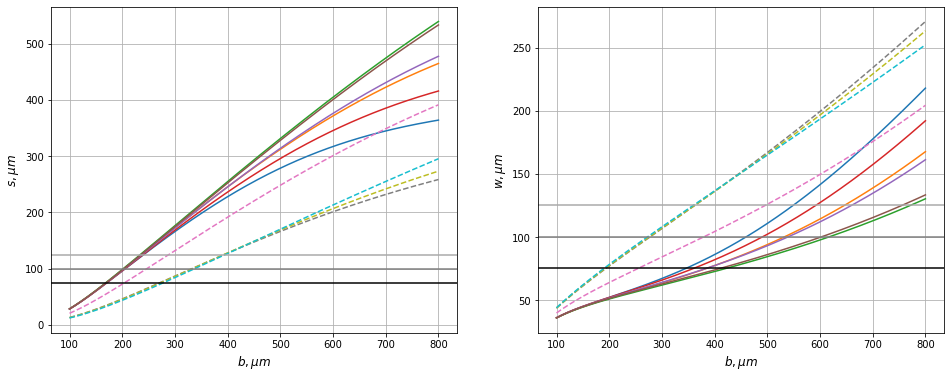

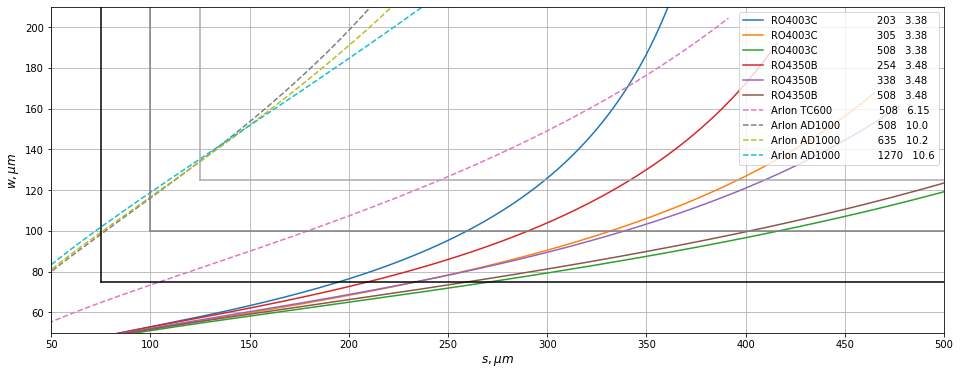

In [83]:
work_array = materials
open_cpw_analyse(work_array, b, shield_height)
# Все по 18 мкм!!!!!!!
# print(work_array)